<a href="https://colab.research.google.com/github/AlexTako/AI_practice/blob/main/Convolutional%20neural%20network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Решенные задачи:

1. Использовался датасет "Собаки и кошки"
2. Провел аугментацию изображений.
3. В качестве предобученной модели взял `MobileNet`
4. Создал модель
5. Обучил модель и проверил на тестовой выборке.



In [ ]:
from keras.applications import MobileNet
from keras import models
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras import optimizers

# def model_maker():
#     base_model = MobileNet(include_top=False, input_shape = (IMG_WIDTH, IMG_HEIGHT, 3))

#     for layer in base_model.layers[:]:
#         layer.trainable = False

#     input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
#     custom_model = base_model(input)
#     custom_model = GlobalAveragePooling2D()(custom_model)
#     custom_model = Dense(64, activation='relu')(custom_model)
#     custom_model = Dropout(0.5)(custom_model)
#     predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)

#     return Model(inputs=input, outputs=predictions)

In [ ]:
# model_maker.summary()

In [ ]:
base_model = MobileNet(include_top=False, input_shape = (192, 192, 3))

In [ ]:
base_model.summary()

Model: "mobilenet_1.00_192"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 96, 96, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 96, 96, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 96, 96, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 96, 96, 32)        288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 96, 96, 32) 

In [ ]:
# Ваше решение

!wget https://storage.yandexcloud.net/academy.ai/cat-and-dog.zip
# Разархивируем датасета во временную папку 'temp'
!unzip -qo "cat-and-dog" -d ./temp

import os

# Набор утилит для работы с файловой системой
import shutil
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = './temp/training_set/training_set/'

# Папка в которой будем создавать выборки
BASE_DIR = './dataset/'

# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# При повторном запуске пересоздаим структуру каталогов
# Если папка существует, то удаляем ее со всеми вложенными каталогами и файлами
if os.path.exists(BASE_DIR):
    shutil.rmtree(BASE_DIR)

# Создаем папку по пути BASE_DIR
os.mkdir(BASE_DIR)

# Сцепляем путь до папки с именем вложенной папки. Аналогично BASE_DIR + '/train'
train_dir = os.path.join(BASE_DIR, 'train')

# Создаем подпапку, используя путь
os.mkdir(train_dir)

# Сцепляем путь до папки с именем вложенной папки. Аналогично BASE_DIR + '/validation'
validation_dir = os.path.join(BASE_DIR, 'validation')

# Создаем подпапку, используя путь
os.mkdir(validation_dir)

# Сцепляем путь до папки с именем вложенной папки. Аналогично BASE_DIR + '/test'
test_dir = os.path.join(BASE_DIR, 'test')

# Создаем подпапку, используя путь
os.mkdir(test_dir)

def create_dataset(
    img_path: str,
    new_path: str,
    class_name: str,
    start_index: int,
    end_index: int):

    src_path = os.path.join(img_path, class_name)  # Полный путь к папке с изображениями класса
    dst_path = os.path.join(new_path, class_name)  # Полный путь к папке с новым датасетом класса

    # Получение списка имен файлов с изображениями текущего класса
    class_files = os.listdir(src_path)

    # Создаем подпапку, используя путь
    os.mkdir(dst_path)

    for fname in class_files[start_index : end_index]:
        src = os.path.join(src_path, fname)
        dst = os.path.join(dst_path, fname)
        shutil.copyfile(src, dst)

for class_label in range(CLASS_COUNT):    # Перебор по всем классам по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен

    create_dataset(IMAGE_PATH, train_dir, class_name, 0, 2000)
    create_dataset(IMAGE_PATH, validation_dir, class_name, 2000, 3000)
    create_dataset(IMAGE_PATH, test_dir, class_name, 3000, 4000)

--2024-03-06 10:53:19--  https://storage.yandexcloud.net/academy.ai/cat-and-dog.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228082266 (218M) [application/x-zip-compressed]
Saving to: ‘cat-and-dog.zip.1’

cat-and-dog.zip.1   100%[===================>] 217.52M  10.7MB/s    in 24s     

2024-03-06 10:53:45 (9.20 MB/s) - ‘cat-and-dog.zip.1’ saved [228082266/228082266]



In [ ]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 6, 6, 1024))
    labels = np.zeros(shape=(sample_count, 2))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(192, 192),
        batch_size=batch_size,
        class_mode='categorical'
    )
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = base_model.predict(inputs_batch, verbose=0)
        features[i * batch_size : (i + 1) * batch_size] = features_batch

        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1

        if i * batch_size >= sample_count:
            break

    return features, labels

train_features, train_labels = extract_features(train_dir, 4000)
validation_features, validation_labels = extract_features(validation_dir, 2000)
test_features, test_labels = extract_features(test_dir, 2000)

Found 4000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
train_features = np.reshape(train_features, (4000, 6 * 6 * 1024))
validation_features = np.reshape(validation_features, (2000, 6 * 6 * 1024))
test_features = np.reshape(test_features, (2000, 6 * 6 * 1024))

In [ ]:
from keras import models
from keras import layers
from keras import optimizers
model = models.Sequential()

# Обратите внимание на размерность входа
model.add(layers.Dense(512, activation='relu', input_dim=6 * 6 * 1024))
model.add(layers.Dropout(0.5)) # Добавим прореживание для борьбы с переобучением
model.add(layers.Dense(2, activation='sigmoid'))
model.compile(
    optimizer=optimizers.Adam(learning_rate=2e-5),
    loss='binary_crossentropy',
    metrics=['acc']
)

history = model.fit(
    train_features, train_labels,
    epochs=30,
    batch_size=20,
    validation_data=(validation_features, validation_labels)
)


Epoch 1/30
200/200 [==============================] - 6s 14ms/step - loss: 0.1728 - acc: 0.9465 - val_loss: 0.0620 - val_acc: 0.9765
Epoch 2/30
200/200 [==============================] - 2s 9ms/step - loss: 0.0308 - acc: 0.9915 - val_loss: 0.0529 - val_acc: 0.9780
Epoch 3/30
200/200 [==============================] - 2s 9ms/step - loss: 0.0116 - acc: 0.9983 - val_loss: 0.0520 - val_acc: 0.9795
Epoch 4/30
200/200 [==============================] - 2s 12ms/step - loss: 0.0071 - acc: 0.9992 - val_loss: 0.0483 - val_acc: 0.9805
Epoch 5/30
200/200 [==============================] - 2s 9ms/step - loss: 0.0044 - acc: 0.9995 - val_loss: 0.0518 - val_acc: 0.9815
Epoch 6/30
200/200 [==============================] - 2s 9ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.0498 - val_acc: 0.9820
Epoch 7/30
200/200 [==============================] - 2s 9ms/step - loss: 0.0020 - acc: 0.9998 - val_loss: 0.0503 - val_acc: 0.9820
Epoch 8/30
200/200 [==============================] - 2s 9ms/step - loss: 

In [ ]:
import matplotlib.pyplot as plt

def show_history(store):
    acc = store.history['acc']
    val_acc = store.history['val_acc']
    loss = store.history['loss']
    val_loss = store.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')
    plt.plot(epochs, val_acc, 'bo', label='Точность на проверочной выборке')
    plt.title('График точности на проверочной и обучающей выборках')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')
    plt.plot(epochs, val_loss, 'bo', label='Потери на проверочной выборке')
    plt.title('График потерь на проверочной и обучающей выборках')
    plt.legend()
    plt.show()

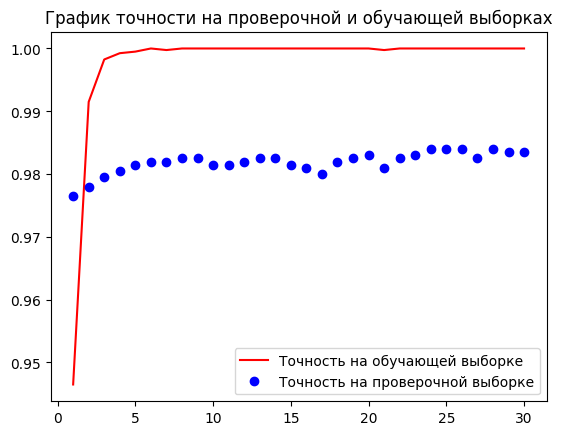

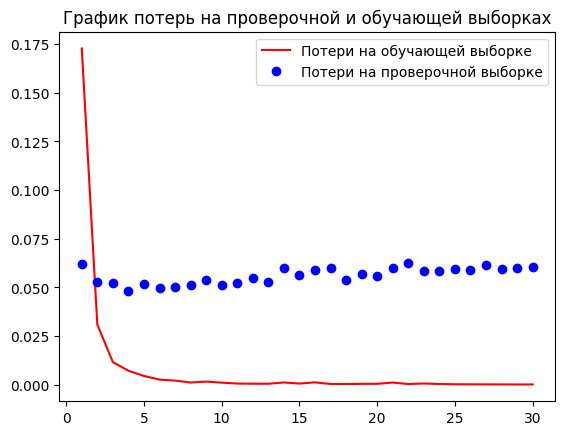

In [ ]:
show_history(history)

In [ ]:
# Второй способ
from keras import models
from keras import layers
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_192 (Functi  (None, 6, 6, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)            (None, 512)               524800    
                                                                 
 dense_13 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 3754690 (14.32 MB)
Trainable params: 3732802 (14.24 MB)
Non-trainable params: 21888 (85.50 KB)
_________________________________________________________________


In [ ]:
for layer in base_model.layers[:]:
        layer.trainable = False

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(192, 192),
    batch_size=20,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(192, 192),
    batch_size=20,
    class_mode='categorical'
)

model.compile(loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=2e-5),
    metrics=['acc']
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)


Found 4000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


<ipython-input-35-eaece1856b4b>:35: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/30
100/100 [==============================] - 27s 243ms/step - loss: 0.5554 - acc: 0.7630 - val_loss: 0.3216 - val_acc: 0.9420
Epoch 2/30
100/100 [==============================] - 24s 237ms/step - loss: 0.2889 - acc: 0.9350 - val_loss: 0.1771 - val_acc: 0.9660
Epoch 3/30
100/100 [==============================] - 23s 232ms/step - loss: 0.2075 - acc: 0.9510 - val_loss: 0.1339 - val_acc: 0.9730
Epoch 4/30
100/100 [==============================] - 23s 225ms/step - loss: 0.1700 - acc: 0.9525 - val_loss: 0.1033 - val_acc: 0.9750
Epoch 5/30
100/100 [==============================] - 23s 235ms/step - loss: 0.1429 - acc: 0.9610 - val_loss: 0.0944 - val_acc: 0.9740
Epoch 6/30
100/100 [==============================] - 23s 233ms/step - loss: 0.1315 - acc: 0.9600 - val_loss: 0.0870 - val_acc: 0.9750
Epoch 7/30
100/100 [==============================] - 23s 227ms/step - loss: 0.1241 - acc: 0.9570 - val_loss: 0.0883 - val_acc: 0.9720
Epoch 8/30
100/100 [==============================] - 2

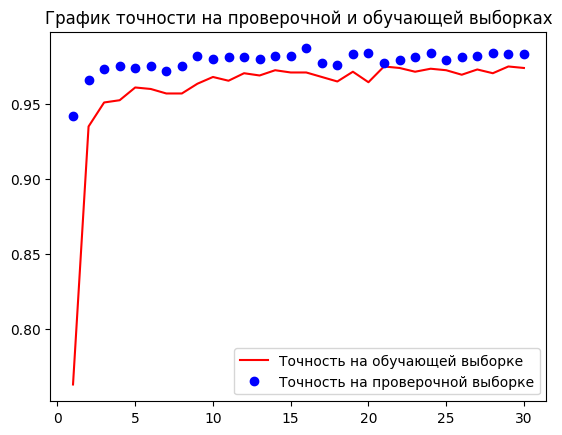

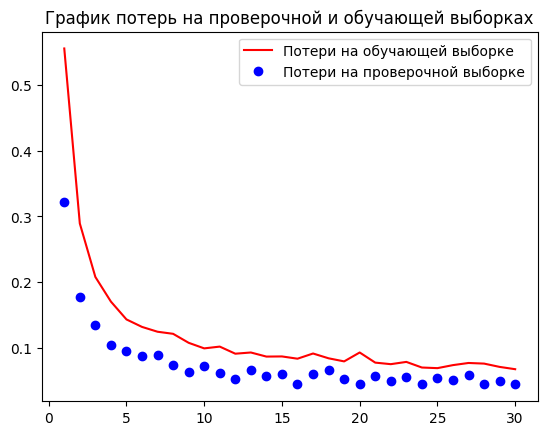

In [ ]:
show_history(history)